<a href="https://colab.research.google.com/github/ssnirgudkar/UNet/blob/main/maskr_cnn_training_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##This is to use Mask R CNN to retrain using our image. It uses weights from coco dataset. Use these weights and then retrain

1. used coco mask r-cnn weights, to infer IR images - it works, gives boxes, + mask for the IR images. However, only identifies boat as that is the only class
2. Saved the unet model weights in h5 format, then used these weights instead of coco mask rcnn weights to see what happens. it doesnt work. gives some obstacles, but not correct. which means we will have to train mask r-cnn with our images - problem is they only are masked, do not have bounding boxes

In [ ]:
!pip install numpy scipy
!pip install pillow scikit-image matplotlib imutils
!pip install "IPython[all]"
!pip install tensorflow-gpu # or tensorflow-gpu
!pip install keras h5py

In [2]:
!pip install opencv-contrib-python

In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git


Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
!cd "drive/My Drive/mask-r-cnn-3-classes-dataset"

Mounted at /content/drive


In [4]:
cd Mask_RCNN

/content/Mask_RCNN


In [ ]:
!sudo python setup.py install

In [ ]:
pip show mask-rcnn

In [ ]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
print ("root directory is", ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize


In [34]:
# Path to trained weights file
COCO_WEIGHTS_PATH = "/content/drive/MyDrive/Models/mask_rcnn_coco.h5"

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = "/content/Mask_RCNN/samples/ir"

# Results directory
# Save submission files here
RESULTS_DIR = "/content/drive/MyDrive/mask-r-cnn-3-classes-dataset/results"

# The dataset doesn't have a standard train/val split, so I picked
# a variety of images to surve as a validation set.
VAL_IMAGE_IDS = [
    "1622943528.194705.png"]

In [10]:
############################################################
#  Configurations
############################################################

class NucleusConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "nucleus"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + sky + water + object

    # Number of training and validation steps per epoch
    #STEPS_PER_EPOCH = (657 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    STEPS_PER_EPOCH = (2 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, len(VAL_IMAGE_IDS) // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400

class NucleusInferenceConfig(NucleusConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

In [65]:
1############################################################
#  Dataset
############################################################

class NucleusDataset(utils.Dataset):

    def load_nucleus(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.
        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("nucleus", 1, "sky")
        self.add_class("nucleus", 2, "water")
        self.add_class("nucleus", 3, "object")


        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val"]
        subset_dir = "images" if subset in ["train", "val"] else subset
        #dataset_dir = "/content/drive/MyDrive/mask-r-cnn-3-classes-dataset"
        dataset_dir = os.path.join(dataset_dir, subset_dir)
        print ("dataset dir path", dataset_dir)
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            image_ids = os.listdir(dataset_dir)
            #image_ids = "1571161450"
            if subset == "train":
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))
                print("length of image ids", len(image_ids))
                #image_ids = "1571161450"

        # Add images
        for image_id in os.listdir(dataset_dir):
            image_name_without_ext = image_id[:-4] # remove file extension
            #print("image_id={0}".format(image_name_without_ext))
            self.add_image(
                "nucleus",
                image_id=image_name_without_ext,
                path=os.path.join(dataset_dir, image_id))
            
            #print(os.path.join(dataset_dir, image_id))
            #path = "/content/Mask_RCNN/samples/ir/images/1571161450.png")  

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "masks")
        #mask_dir = "/content/Mask_RCNN/samples/ir/masks"
        print("path of masks directory", mask_dir)
        # Read mask files from .png image
        mask = []
        for f in os.listdir(mask_dir):
          #print ("mask image = {}".format(f))
          if f.endswith(".png"):
            m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
            #m = skimage.io.imread("/content/Mask_RCNN/samples/ir/masks/1571161450.png").astype(np.bool)
            mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nucleus":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [20]:
config = NucleusConfig()

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

In [22]:
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [66]:
############################################################
#  Training
############################################################


#def train(model, dataset_dir, subset):
"""Train the model."""
# Training dataset.
dataset_train = NucleusDataset()
dataset_train.load_nucleus("/content/drive/MyDrive/mask-r-cnn-3-classes-dataset", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = NucleusDataset()
dataset_val.load_nucleus("/content/drive/MyDrive/mask-r-cnn-3-classes-dataset", "val")
dataset_val.prepare()


dataset dir path /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/images
length of image ids 21
dataset dir path /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/images


In [67]:
# Image augmentation
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.SomeOf((0, 2), [
iaa.Fliplr(0.5),
iaa.Flipud(0.5),
iaa.OneOf([iaa.Affine(rotate=90),
          iaa.Affine(rotate=180),
          iaa.Affine(rotate=270)]),
          iaa.Multiply((0.8, 1.5)),
          iaa.GaussianBlur(sigma=(0.0, 5.0))
])

# *** This training schedule is an example. Update to your needs ***

# If starting from imagenet, train heads only for a bit
# since they have random weights
#print("Train network heads")
'''
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                #epochs=20,
                epochs=1,
                augmentation=augmentation,
                layers='heads')
'''
print("Train all layers")
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                #epochs=40,
                epochs=1, 
                augmentation=augmentation,
                layers='all')


Train all layers

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/samples/ir/nucleus20210802T0959/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
Epoch 1/1
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path o

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks directory /content/drive/MyDrive/mask-r-cnn-3-classes-dataset/masks
path of masks di

Re-starting from epoch 0
Processing 1 images
image                    shape: (256, 320, 3)         min:    7.00000  max:  236.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -41.22000  max:  195.44000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


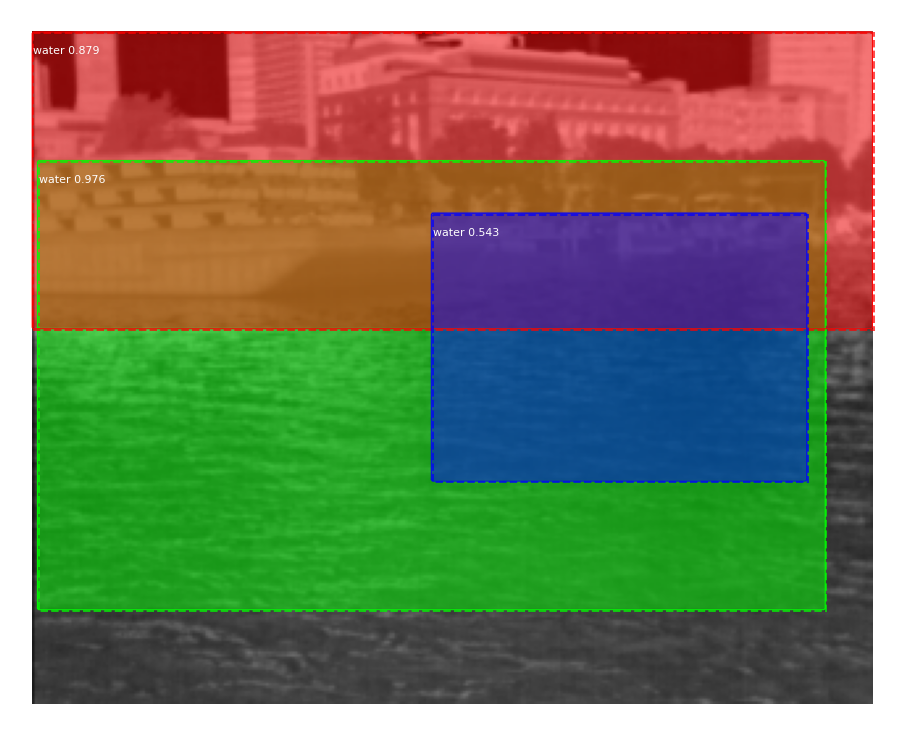

In [80]:
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

model = modellib.MaskRCNN(mode="inference", model_dir='/content/Mask_RCNN/samples/ir', config=config)

model.load_weights('/content/Mask_RCNN/samples/ir/nucleus20210802T0959/mask_rcnn_nucleus_0000.h5', by_name=True)


#img = load_img('/content/drive/MyDrive/mask-r-cnn-3-classes-dataset/images/1571161601.714305.png')
#img = img_to_array(img)
image = skimage.io.imread('/content/drive/MyDrive/mask-r-cnn-3-classes-dataset/images/1571161601.714305.png') 

class_names = ['sky', 'water', 'obstacle']

# make prediction
results = model.detect([image], verbose=1)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [76]:
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 3
 
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('/content/Mask_RCNN/samples/ir/nucleus20210802T0959/mask_rcnn_nucleus_0000.h5', by_name=True)
#rcnn.load_weights('/content/drive/MyDrive/Models/h5model_unet1-0.h5', by_name=True)
# load photograph
img = load_img('/content/drive/MyDrive/mask-r-cnn-3-classes-dataset/images/1571161601.714305.png')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

NameError: ignored

In [15]:
############################################################
#  RLE Encoding
############################################################

def rle_encode(mask):
    """Encodes a mask in Run Length Encoding (RLE).
    Returns a string of space-separated values.
    """
    assert mask.ndim == 2, "Mask must be of shape [Height, Width]"
    # Flatten it column wise
    m = mask.T.flatten()
    # Compute gradient. Equals 1 or -1 at transition points
    g = np.diff(np.concatenate([[0], m, [0]]), n=1)
    # 1-based indicies of transition points (where gradient != 0)
    rle = np.where(g != 0)[0].reshape([-1, 2]) + 1
    # Convert second index in each pair to lenth
    rle[:, 1] = rle[:, 1] - rle[:, 0]
    return " ".join(map(str, rle.flatten()))


def rle_decode(rle, shape):
    """Decodes an RLE encoded list of space separated
    numbers and returns a binary mask."""
    rle = list(map(int, rle.split()))
    rle = np.array(rle, dtype=np.int32).reshape([-1, 2])
    rle[:, 1] += rle[:, 0]
    rle -= 1
    mask = np.zeros([shape[0] * shape[1]], np.bool)
    for s, e in rle:
        assert 0 <= s < mask.shape[0]
        assert 1 <= e <= mask.shape[0], "shape: {}  s {}  e {}".format(shape, s, e)
        mask[s:e] = 1
    # Reshape and transpose
    mask = mask.reshape([shape[1], shape[0]]).T
    return mask


def mask_to_rle(image_id, mask, scores):
    "Encodes instance masks to submission format."
    assert mask.ndim == 3, "Mask must be [H, W, count]"
    # If mask is empty, return line with image ID only
    if mask.shape[-1] == 0:
        return "{},".format(image_id)
    # Remove mask overlaps
    # Multiply each instance mask by its score order
    # then take the maximum across the last dimension
    order = np.argsort(scores)[::-1] + 1  # 1-based descending
    mask = np.max(mask * np.reshape(order, [1, 1, -1]), -1)
    # Loop over instance masks
    lines = []
    for o in order:
        m = np.where(mask == o, 1, 0)
        # Skip if empty
        if m.sum() == 0.0:
            continue
        rle = rle_encode(m)
        lines.append("{}, {}".format(image_id, rle))
    return "\n".join(lines)



In [16]:
############################################################
#  Detection
############################################################

def detect(model, dataset_dir, subset):
    """Run detection on images in the given directory."""
    print("Running on {}".format(dataset_dir))

    # Create directory
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    submit_dir = "submit_{:%Y%m%dT%H%M%S}".format(datetime.datetime.now())
    submit_dir = os.path.join(RESULTS_DIR, submit_dir)
    os.makedirs(submit_dir)

    # Read dataset
    dataset = NucleusDataset()
    dataset.load_nucleus(dataset_dir, subset)
    dataset.prepare()
    # Load over images
    submission = []
    for image_id in dataset.image_ids:
        # Load image and run detection
        image = dataset.load_image(image_id)
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Encode image to RLE. Returns a string of multiple lines
        source_id = dataset.image_info[image_id]["id"]
        rle = mask_to_rle(source_id, r["masks"], r["scores"])
        submission.append(rle)
        # Save image with masks
        visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=False, show_mask=False,
            title="Predictions")
        plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))

# Save to csv file
    submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
    file_path = os.path.join(submit_dir, "submit.csv")
    with open(file_path, "w") as f:
        f.write(submission)
    print("Saved to ", submit_dir)


In [25]:
dataset = NucleusDataset()
dataset.load_nucleus(dataset_dir = "/content/Mask_RCNN/samples/ir/images", subset="train")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 1
Class Count: 4
  0. BG                                                
  1. sky                                               
  2. water                                             
  3. object                                            
